<h2><strong>Project Overview: Predicting Passenger Survival on the Titanic</strong></h2>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

<h3><strong>Step 1: Data Exploration and Initial Analysis</strong></h3>

In [2]:
df = pd.read_csv("titanic_train.csv")

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<h3><strong>Step 2: Handling Missing Data</strong></h3>

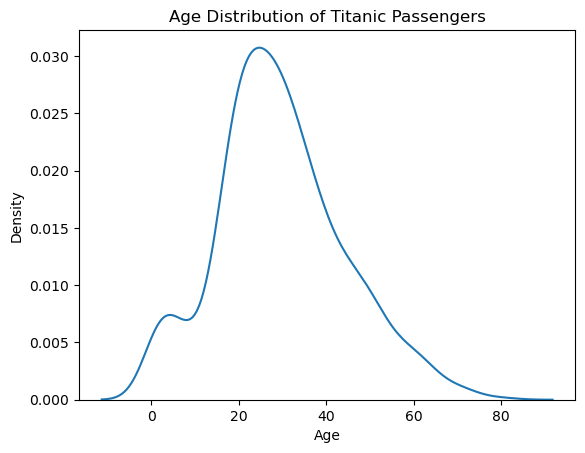

In [6]:
sns.kdeplot(data=df["Age"])  # Feature is skewed with outliers
plt.title("Age Distribution of Titanic Passengers")

df["Age"] = df["Age"].fillna(value=df["Age"].median())

In [7]:
df["Embarked"] = df["Embarked"].fillna(value=df["Embarked"].mode())

In [8]:
df["HasCabin"] = np.where(df["Cabin"].notna(), 1, 0)
df = df.drop(columns=["Cabin"])

<h3><strong>Step 3: Encoding Categorical Features</strong></h3>
</ul>

In [9]:
df = df.drop(columns=["Ticket", "PassengerId"])
df = pd.get_dummies(df, columns=["Sex", "Embarked"], drop_first=True, dtype=int)

In [10]:
df["Hon"] = (
    df["Name"]
    .str.split(pat=", ", n=1, expand=True)[1]
    .str.split(pat=".", expand=True)[0]
)  # Extract honorifics from name
hon_map = {
    "Mlle": "Miss",
    "Ms": "Miss",
    "Mme": "Mrs",
    "Lady": "Mrs",
}
df["Hon"] = df["Hon"].replace(hon_map)  # Rename categories that mean the same
df["Hon"] = np.where(
    df["Hon"].isin(["Mr", "Miss", "Mrs", "Master"]), df["Hon"], "Other"
)  # Group minority categories together to reduce computation
df = df.drop(columns="Name")
df = pd.get_dummies(df, columns=["Hon"], drop_first=True, dtype=int)

<h3><strong>Step 4: Prepare Data for Modeling</strong></h3>

In [11]:
y = df["Survived"]
X = df.drop(columns=["Survived"])

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=17, stratify=y
)

<h3><strong>Step 5: Feature Scaling</strong></h3>

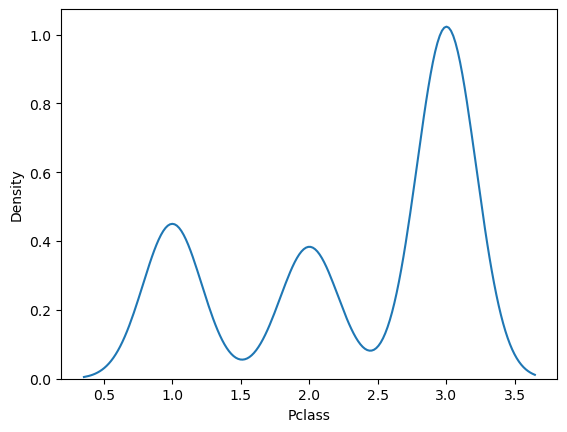

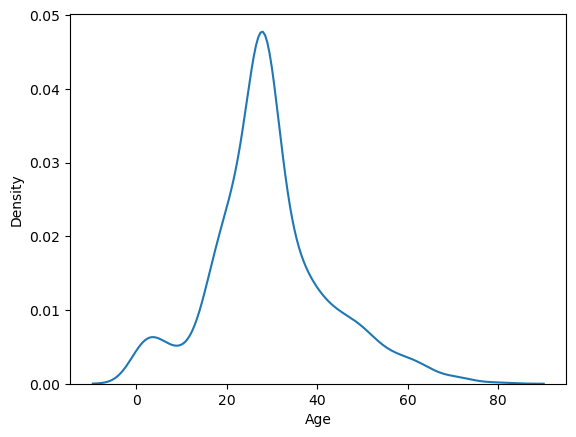

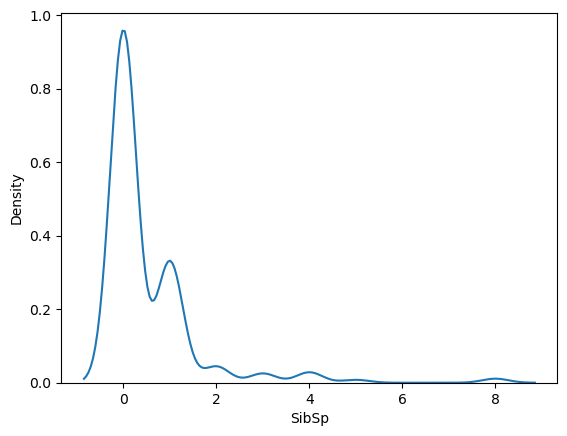

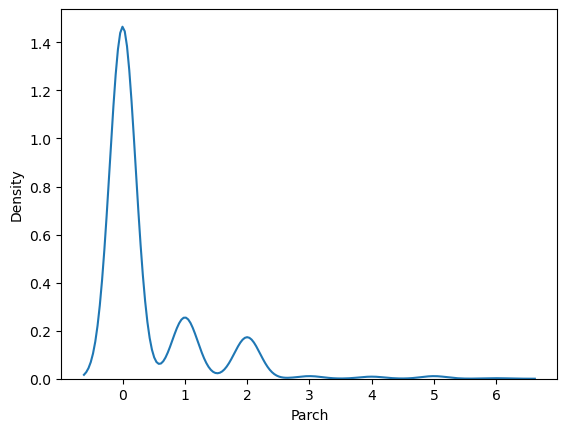

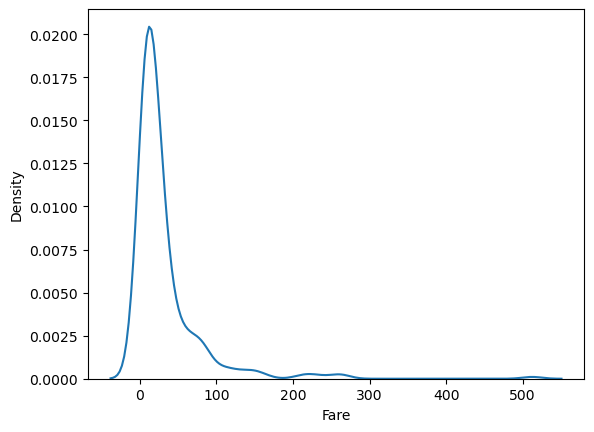

In [13]:
cols_to_scale = ["Pclass", "Age", "SibSp", "Parch", "Fare"]


for i, col in enumerate(cols_to_scale):
    plt.figure(i)
    sns.kdeplot(X[col])

In [14]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler


transformer = make_column_transformer(
    (RobustScaler(), cols_to_scale), remainder="passthrough"
)

X_train_scaled = pd.DataFrame(
    transformer.fit_transform(X_train), columns=X_train.columns
)
X_valid_scaled = pd.DataFrame(transformer.transform(X_valid), columns=X_train.columns)

<h3><strong>Step 6: Feature Selection and Modeling</strong></h3>

In [15]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(
    penalty="l1", random_state=17, solver="liblinear", max_iter=1000
)  # We set max_iter=1000 to ensure the solver has enough iterations to converge and find the optimal model weights, preventing a ConvergenceWarning.
lg.fit(X_train_scaled, y_train)
coef_l1 = pd.Series(lg.coef_[0], index=X_train_scaled.columns)
coef_l1.sort_values(ascending=False)

Hon_Mrs       0.868235
HasCabin      0.563125
Fare          0.100158
Sex_male      0.000000
Embarked_Q    0.000000
Hon_Miss      0.000000
Embarked_S   -0.274869
Parch        -0.393588
SibSp        -0.434994
Age          -0.498958
Pclass       -0.948595
Hon_Other    -2.197896
Hon_Mr       -2.760987
dtype: float64

In [16]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=17)
rfc.fit(X_train_scaled, y_train)
coef_rf = pd.Series(rfc.feature_importances_, index=X_train_scaled.columns).sort_values(
    ascending=False
)

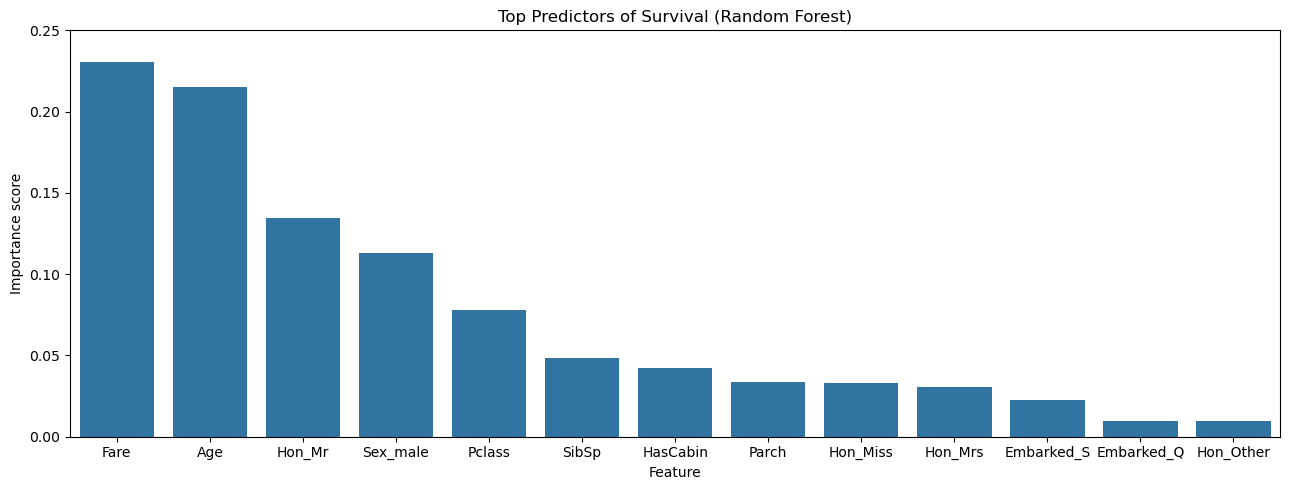

In [17]:
plt.figure(figsize=(13, 5))
sns.barplot(coef_rf)
plt.xlabel("Feature")
plt.ylabel("Importance score")
plt.title("Top Predictors of Survival (Random Forest)")
plt.ylim(0, 0.25)
plt.tight_layout()

<h3><strong>Step 7: Analysis and Conclusion</strong></h3>

In [18]:
l1_selected_features = coef_l1[
    coef_l1 != 0
].index  # Remove features with 0 coef. values
rf_selected_features = (
    coef_rf[:6].index
)  # Top 6 features chosen as visible elbow at after 6th feature as shown in line plot

In [19]:
X_train_l1 = X_train_scaled[l1_selected_features]
X_valid_l1 = X_valid_scaled[l1_selected_features]

X_train_rf = X_train_scaled[rf_selected_features]
X_valid_rf = X_valid_scaled[rf_selected_features]

In [20]:
from sklearn.metrics import accuracy_score

lg_base = LogisticRegression(
    penalty="l2", random_state=17, max_iter=1000
)  # l2 will be used this time for consistency and robustness
lg_base.fit(X_train_scaled, y_train)
acc_base_lg = accuracy_score(y_true=y_valid, y_pred=lg_base.predict(X_valid_scaled))

lg_l1 = LogisticRegression(penalty="l2", random_state=17, max_iter=1000)
lg_l1.fit(X_train_l1, y_train)
acc_l1_lg = accuracy_score(y_true=y_valid, y_pred=lg_l1.predict(X_valid_l1))

lg_rf = LogisticRegression(penalty="l2", random_state=17, max_iter=1000)
lg_rf.fit(X_train_rf, y_train)
acc_rf_lg = accuracy_score(y_true=y_valid, y_pred=lg_rf.predict(X_valid_rf))

In [21]:
acc_scores_lg = {
    "Accuracy score (all features)": round(acc_base_lg, 3),
    "Accuracy score (l1 features)": round(acc_l1_lg, 3),
    "Accuracy score (rf features)": round(acc_rf_lg, 3),
}

acc_scores_lg

{'Accuracy score (all features)': 0.821,
 'Accuracy score (l1 features)': 0.827,
 'Accuracy score (rf features)': 0.816}